# 3D parameter estimation using MCMC

Leverages the data produced in `drifter_3D.ipynb`

In [1]:
import xarray as xr
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt

from gptide import cov
from gptide import GPtideScipy
from gptide import stats as gpstats
import corner
import arviz as az

## Define kernels

In [2]:
def kernel_3d(x, xpr, params):
    """
    3D kernel
    
    Inputs:
        x: matrices input points [N,3]
        xpr: matrices output points [M,3]
        params: tuple length 4
            eta: standard deviation
            lx: x length scale
            ly: y length scale
            lt: t length scale
            
    """
    eta, lx, ly, lt = params
    
    # Build the covariance matrix
    C  = cov.matern32(x[:,2,None], xpr.T[:,2,None].T, lt)
    C *= cov.matern32(x[:,1,None], xpr.T[:,1,None].T, ly) 
    C *= cov.matern32(x[:,0,None], xpr.T[:,0,None].T, lx)
    C *= eta**2
    
    return C

covfunc = kernel_3d

## Inference

We now use the `gptide.mcmc` function do the parameter estimation. This uses the `emcee.EnsembleSampler` class.


In [3]:
from gptide import mcmc
#n = len(xd)
#covparams

In [11]:
# load data
ds = xr.open_dataset("uv_3D_selection.nc", decode_times=False)
ds = ds.isel(time=slice(0,None,5), trajectory=slice(0,None,5))# subset
ds = ds.sortby("trajectory")
ds.u.size

96

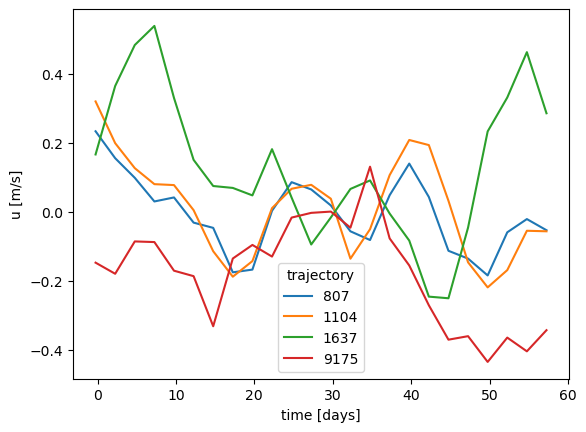

In [18]:
ds.u.plot(hue="trajectory")

In [12]:
x = (ds.time*0. + ds.x   ).values.ravel()
y = (ds.time*0. + ds.y   ).values.ravel()
t = (ds.time    + ds.x*0.).values.ravel()

X = np.hstack([x[:,None], y[:,None], t[:,None]])
u = ds.u.values.ravel()[:, None]

print(X.shape, u.shape)

(96, 3) (96, 1)


In [19]:
# Initial guess of the noise and covariance parameters (these can matter)

noise = 0.01
η = .2
ℓ_x = 100e3 # meters
ℓ_y = 100e3 # meters
ℓ_t = 86400*5 # seconds
covparams = [η, ℓ_x, ℓ_y, ℓ_t]

scale = 5

noise_prior      = gpstats.truncnorm(noise, noise*2, noise/scale, noise*scale)    # noise
covparams_priors = [gpstats.truncnorm(η, η*2, η/scale, η*scale),                  # eta
                    gpstats.truncnorm(ℓ_x, ℓ_x*2, ℓ_x/scale, ℓ_x*scale),          # ℓ_x
                    gpstats.truncnorm(ℓ_y, ℓ_y*2, ℓ_y/scale, ℓ_y*scale),          # ℓ_y
                    gpstats.truncnorm(ℓ_t, ℓ_t*2, ℓ_t/scale, ℓ_t*scale)           # ℓ_t
                   ]

In [20]:
samples, log_prob, priors_out, sampler = mcmc.mcmc(X, 
                                                   u, 
                                                    covfunc, 
                                                    covparams_priors,
                                                    noise_prior,
                                                    nwarmup=30,
                                                    niter=100,
                                                    verbose=False)

Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:18<00:00,  1.60it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.57it/s]


## Find sample with highest log prob

In [21]:
i = np.argmax(log_prob)
MAP = samples[i, :]

print('Noise (true): {:3.2f},  Noise (mcmc): {:3.2f}'.format(noise, MAP[0]))
print('η   (true):   {:3.2f},  η     (mcmc): {:3.2f}'.format(covparams[0],  MAP[1]))
print('ℓ_x (true):   {:3.2f},  ℓ_x   (mcmc): {:3.2f}'.format(covparams[1],  MAP[2]))
print('ℓ_y (true):   {:3.2f},  ℓ_y   (mcmc): {:3.2f}'.format(covparams[2],  MAP[3])) 
print('ℓ_t (true):   {:3.2f},  ℓ_t   (mcmc): {:3.2f}'.format(covparams[3],  MAP[4])) 

Noise (true): 0.01,  Noise (mcmc): 0.05
η   (true):   0.20,  η     (mcmc): 0.84
ℓ_x (true):   100000.00,  ℓ_x   (mcmc): 58760.59
ℓ_y (true):   100000.00,  ℓ_y   (mcmc): 271720.01
ℓ_t (true):   432000.00,  ℓ_t   (mcmc): 673572.10


## Posterior density plot

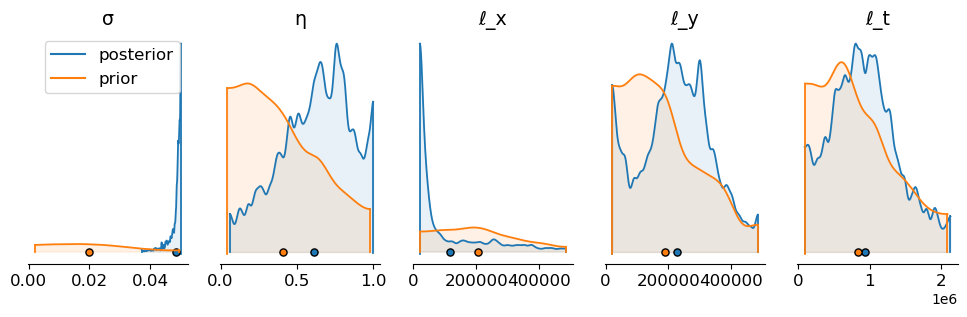

In [22]:
labels = ['σ','η','ℓ_x', 'ℓ_y', 'ℓ_t']
def convert_to_az(d, labels):
    output = {}
    for ii, ll in enumerate(labels):
        output.update({ll:d[:,ii]})
    return az.convert_to_dataset(output)

priors_out_az = convert_to_az(priors_out, labels)
samples_az    = convert_to_az(samples, labels)

axs = az.plot_density(   [samples_az[labels], 
                         priors_out_az[labels]],
                         shade=0.1,
                         grid=(1, 5),
                         textsize=12,
                         figsize=(12,3),
                         data_labels=('posterior','prior'),
                         hdi_prob=0.995)


## Posterior corner plot

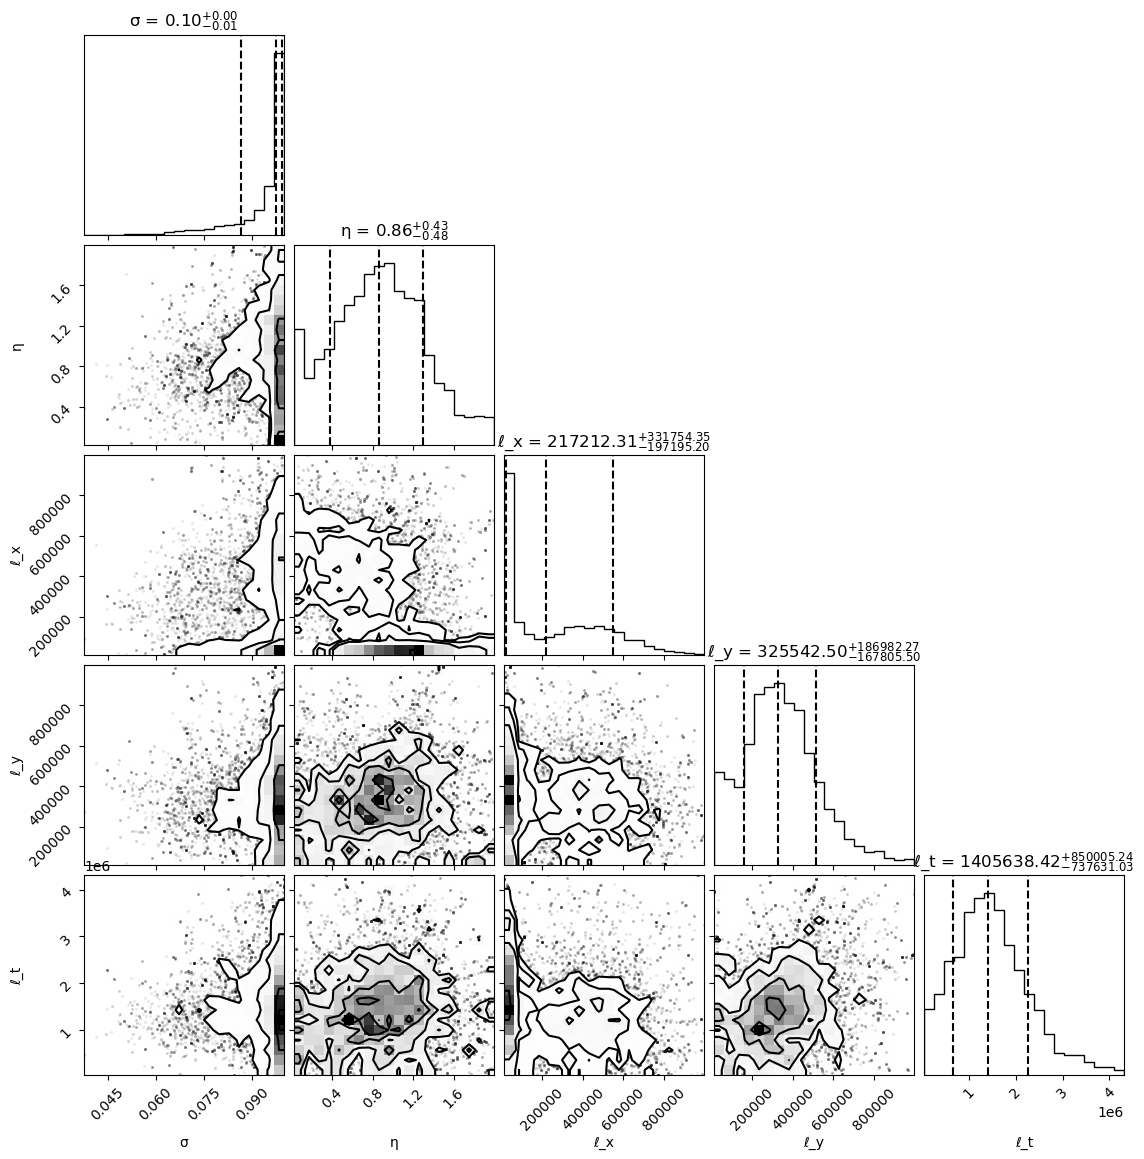

In [17]:
fig = corner.corner(samples, 
                    show_titles=True,
                    labels=labels,
                    plot_datapoints=True,
                    quantiles=[0.16, 0.5, 0.84])

## Condition and make predictions

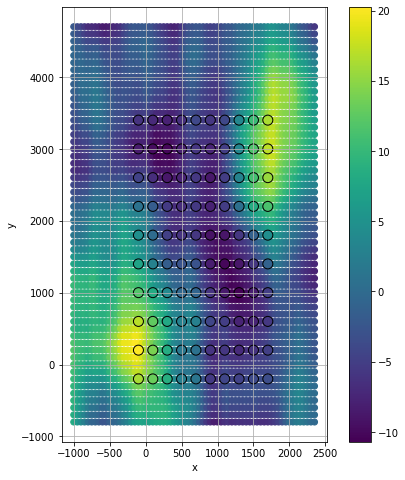

In [11]:
plt.figure(figsize=(8, 8))
plt.ylabel('y')
plt.xlabel('x')

# xo = np.arange(0,dx*N,dx/3)[:,None]
xdo = np.arange(-dx*0.5*N, dx*1.2*N, dx/4)[:,None]
ydo = np.arange(-dy*0.2*N, dy*1.2*N, dy/4)[:,None]

# Make a grid
Xgo, Ygo = np.meshgrid(xdo, ydo)

# Vectorise grid and stack
Xvo = Xgo.ravel()
Yvo = Ygo.ravel()
Xo = np.hstack([Xvo[:,None], Yvo[:,None]])
    
OI = GPtideScipy(X, Xo, 0, covfunc, MAP[1:], 
             P=1, mean_func=None)
out_map = OI.conditional(zd)

plt.scatter(Xgo, Ygo, c=out_map, alpha=1)
plt.scatter(Xg, Yg,   c=zg, s=100, edgecolors='k')

plt.grid()
plt.gca().set_aspect('equal')
plt.colorbar()